In [1]:
#split into train, validation and test set
#train: 80%, validation: 10%, test: 10%
#we have 3 different datasets: OG, balanced and balanced, augmented

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import torchvision.transforms as transforms
import PIL
import matplotlib.pyplot as plt
import torch
import random

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 42

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [5]:
#add the csv file with the labels
labeling = pd.read_csv("./Original_labels.csv")
labeling

filename  item_type    label
0     100_i110.png        100  plastic
1     100_i120.png        100  plastic
2     100_i130.png        100  plastic
3     100_i140.png        100  plastic
4     100_i150.png        100  plastic
...            ...        ...      ...
7747  997_i180.png        997  plastic
7748  997_i190.png        997  plastic
7749  997_i210.png        997  plastic
7750  997_i230.png        997  plastic
7751  997_i250.png        997  plastic

[7752 rows x 3 columns]

In [6]:
#list of unique item types
unique_item_type = labeling['item_type'].unique()

In [7]:
#shuffle the data based on item_type
item_shuffle = np.random.permutation(unique_item_type)
train_item_type = item_shuffle[:int(len(item_shuffle)*0.8)]
test_item_type = item_shuffle[int(len(item_shuffle)*0.8):int(len(item_shuffle)*0.9)]
val_item_type = item_shuffle[int(len(item_shuffle)*0.9):]

In [8]:
#train test val dataframes
train_df = labeling[labeling['item_type'].isin(train_item_type)]
test_df = labeling[labeling['item_type'].isin(test_item_type)]
val_df = labeling[labeling['item_type'].isin(val_item_type)]

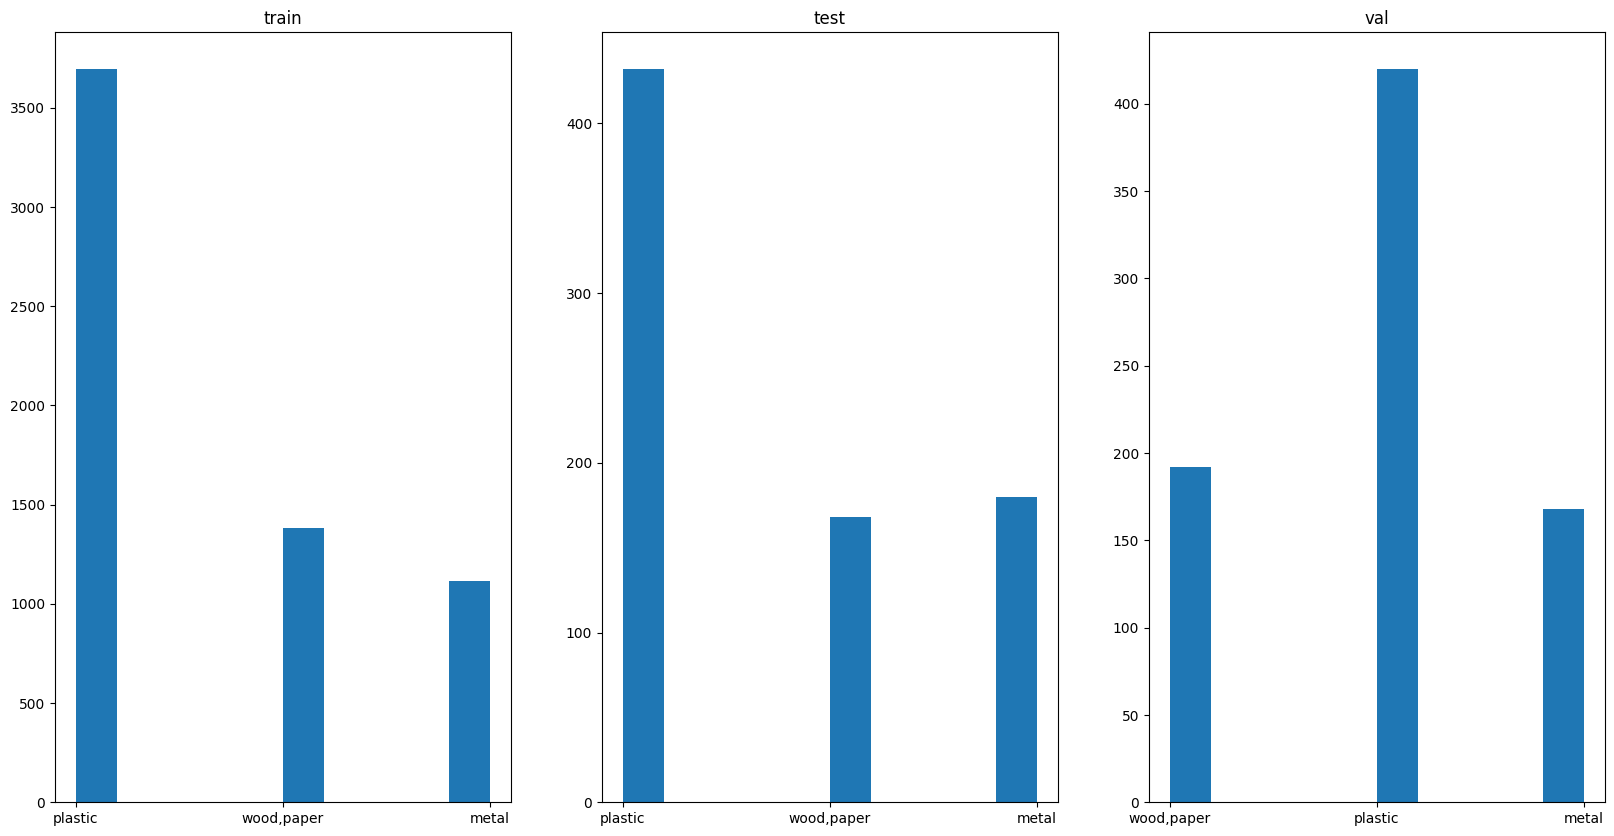

In [9]:
#histogram of the material types train val test
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.hist(train_df['label'])
plt.title('train')
plt.subplot(1,3,2)
plt.hist(test_df['label'])
plt.title('test')
plt.subplot(1,3,3)
plt.hist(val_df['label'])
plt.title('val')
plt.show()


In [10]:
source_dir = './Filtered/'
target_dir = './trainvaltestOG/'

In [11]:
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

In [12]:
#copy files into train/val/test based on split
if (not os.path.exists(target_dir + "train") and not os.path.exists(target_dir + "val") and not os.path.exists(target_dir + "test")):
    os.mkdir(target_dir + "train")
    os.mkdir(target_dir + "val")
    os.mkdir(target_dir + "test")

for item in train_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        shutil.copy(source_dir + row['filename'], target_dir + "train/" + row['filename'])

for item in val_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        shutil.copy(source_dir + row['filename'], target_dir + "val/" + row['filename'])

for item in test_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        shutil.copy(source_dir + row['filename'], target_dir + "test/" + row['filename'])

In [13]:
#save the train test val dataframes
target_dir = './trainvaltestOG/trainvaltestcsv/'
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

#save the dataframes
labeling.to_csv(target_dir + 'all_labeling.csv', index=False)
train_df.to_csv(target_dir + 'train_labeling.csv', index=False)
test_df.to_csv(target_dir + 'test_labeling.csv', index=False)
val_df.to_csv(target_dir + 'val_labeling.csv', index=False)


We call the below if we need balancing

In [14]:
#create a copy of the trainvaltest folder called trainvaltestBalanced

In [15]:
source_dir = './trainvaltestOG/'
target_dir = './trainvaltestBalanced/'

if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#copy files
shutil.copytree(source_dir, target_dir)

'./trainvaltestBalanced/'

In [16]:
#we now balance the train set
metal_count = train_df[train_df['label'] == 'metal'].shape[0]
plastic_count = train_df[train_df['label'] == 'plastic'].shape[0]
wood_paper_count = train_df[train_df['label'] == 'wood,paper'].shape[0]

print("metal_count: ", metal_count)
print("plastic_count: ", plastic_count)
print("wood_paper_count: ", wood_paper_count)

metal_count:  1116
plastic_count:  3696
wood_paper_count:  1380


In [17]:
source_dir = './trainvaltestBalanced/train/'
target_dir = './trainvaltestBalanced/train/'

In [18]:
transforms_list = transforms.Compose([
    transforms.RandomResizedCrop(144, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),transforms.RandomRotation(180),transforms.RandomRotation(270),
     transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip()])

In [19]:
#sample the metal data
metal_sample = train_df[train_df['label'] == 'metal'].sample(n= (plastic_count - metal_count), random_state=seed, replace=True)
metal_sample

filename  item_type  label
6296  830_i190.png        830  metal
7599  982_i140.png        982  metal
7428  961_i110.png        961  metal
973   204_i120.png        204  metal
3082  455_i230.png        455  metal
...            ...        ...    ...
4390  606_i230.png        606  metal
2774  420_i130.png        420  metal
636   166_i110.png        166  metal
7437  961_i210.png        961  metal
1550  279_i130.png        279  metal

[2580 rows x 3 columns]

In [20]:
#apply the augmenation
for i in range(len(metal_sample)):
    img = PIL.Image.open(source_dir+metal_sample.iloc[i]['filename'])
    img = transforms.RandAugment()(img)
    img = transforms_list(img)
    item_type = metal_sample.iloc[i]['item_type']
    augname = metal_sample.iloc[i]['filename'][:-4]+'_aug' + str(i) + '.png'
    img.save(source_dir+augname)
    #add to csv
    labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
    train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)

C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\3132299944.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\3132299944.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\3132299944.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\3132299944.p

In [21]:
#sample the wood,paper data
wood_paper_sample = train_df[train_df['label'] == 'wood,paper'].sample(n= (plastic_count - wood_paper_count), random_state=seed, replace=True)
wood_paper_sample

filename  item_type       label
5254  858_i230.png        858  wood,paper
4160  688_i190.png        688  wood,paper
5782   94_i230.png         94  wood,paper
5270  861_i130.png        861  wood,paper
5127  841_i140.png        841  wood,paper
...            ...        ...         ...
4599  771_i140.png        771  wood,paper
2444  458_i190.png        458  wood,paper
5134  841_i230.png        841  wood,paper
5456  900_i190.png        900  wood,paper
4803  803_i140.png        803  wood,paper

[2316 rows x 3 columns]

In [22]:
#apply the augmenation
for i in range(len(wood_paper_sample)):
    img = PIL.Image.open(source_dir+wood_paper_sample.iloc[i]['filename'])
    img = transforms.RandAugment()(img)
    img = transforms_list(img)
    item_type = wood_paper_sample.iloc[i]['item_type']
    augname = wood_paper_sample.iloc[i]['filename'][:-4]+'_aug' + str(i) + '.png'
    img.save(source_dir+augname)
    #add to csv
    labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
    train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)

C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\708481795.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\708481795.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\708481795.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\

Text(0.5, 1.0, 'train')

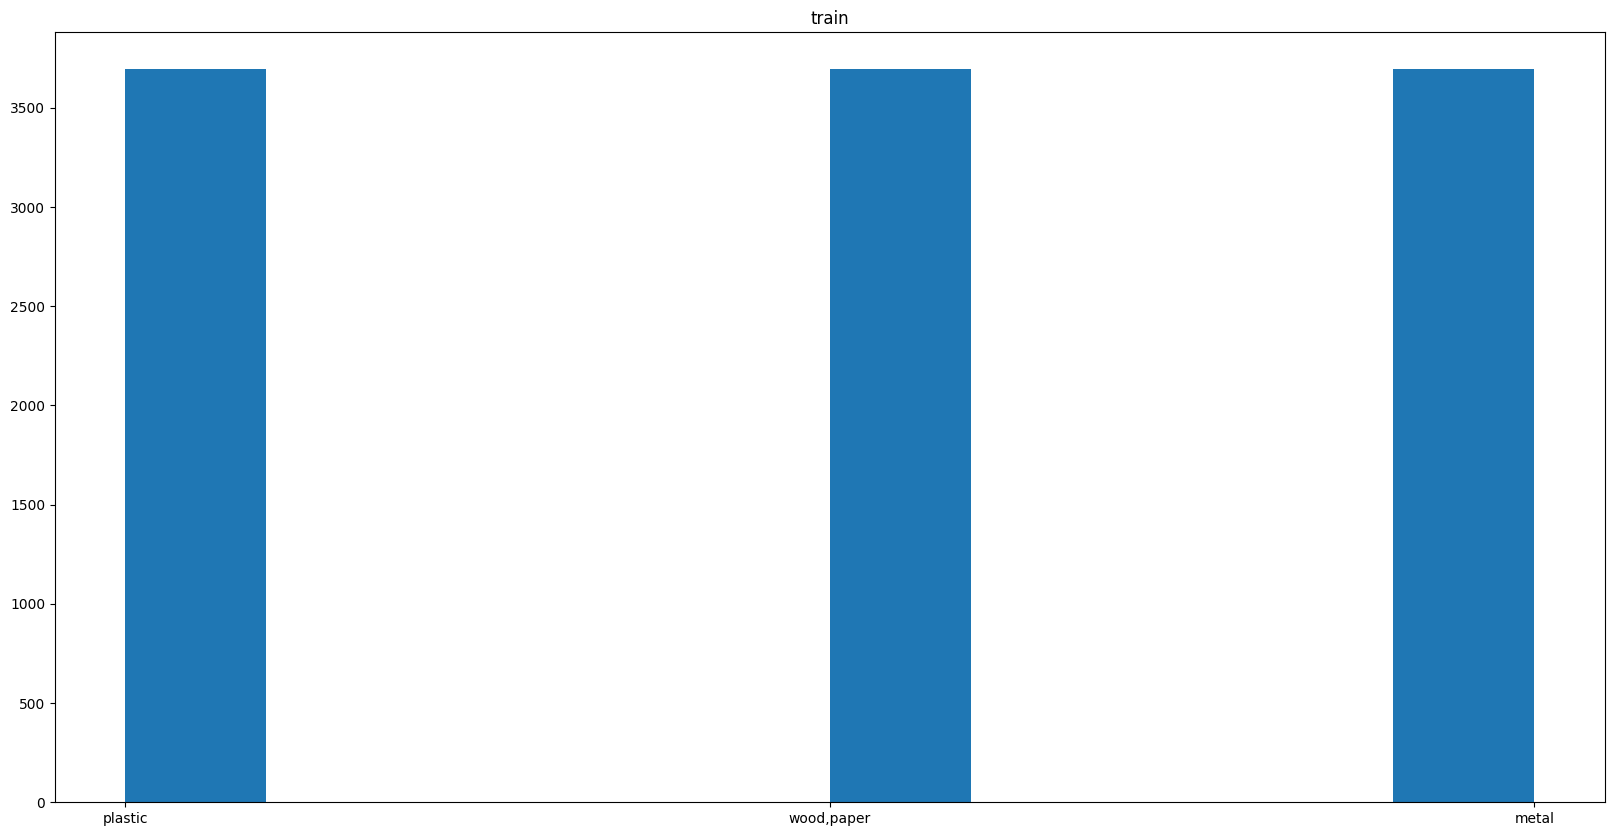

In [23]:
#histogram of the material types train val test
plt.figure(figsize=(20,10))
plt.hist(train_df['label'])
plt.title('train')

In [24]:
#save the new csv
target_dir = './trainvaltestBalanced/trainvaltestcsv/'
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

labeling.to_csv(target_dir + 'all_labeling.csv', index=False)
train_df.to_csv(target_dir + 'train_labeling.csv', index=False)
test_df.to_csv(target_dir + 'test_labeling.csv', index=False)
val_df.to_csv(target_dir + 'val_labeling.csv', index=False)

In [25]:
#We now augment the train with 2000 images
#technique: random crop, random rotation, random horizontal flip, random vertical flip, random erase


In [26]:
#copy the trainvaltestBalanced folder to trainvaltestBalancedAugmented
source_dir = './trainvaltestBalanced/'
target_dir = './trainvaltestBalancedAugmented/'

#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#copy files
shutil.copytree(source_dir, target_dir)

'./trainvaltestBalancedAugmented/'

In [27]:
source_dir = "./trainvaltestBalancedAugmented/train/"
pd_label = pd.read_csv('./trainvaltestBalancedAugmented/trainvaltestcsv/train_labeling.csv')
augment_count = 2000

In [28]:
transforms_list = transforms.Compose([
    transforms.RandomResizedCrop(144, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),transforms.RandomRotation(180),transforms.RandomRotation(270),
     transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip()])

In [29]:
#sample plastic
plastic_sample = train_df[train_df['label'] == 'plastic'].sample(n=augment_count, random_state=seed, replace=True)
plastic_sample

filename  item_type    label
5142  842_i170.png        842  plastic
5883  958_i140.png        958  plastic
1556  338_i190.png        338  plastic
2146  414_i230.png        414  plastic
1922  387_i130.png        387  plastic
...            ...        ...      ...
6012  968_i110.png        968  plastic
3020   53_i190.png         53  plastic
101   111_i160.png        111  plastic
5050  832_i230.png        832  plastic
1194  275_i170.png        275  plastic

[2000 rows x 3 columns]

In [30]:
#apply the augmenation
for i in range(len(plastic_sample)):
    img = PIL.Image.open(source_dir+plastic_sample.iloc[i]['filename'])
    img = transforms_list(img)
    item_type = plastic_sample.iloc[i]['item_type']
    augname = plastic_sample.iloc[i]['filename'][:-4]+'_augX' + str(i) + '.png'
    img.save(source_dir+augname)
    #add to csv
    labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'plastic'}, ignore_index=True)
    train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'plastic'}, ignore_index=True)

C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\1797727102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'plastic'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\1797727102.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'plastic'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\1797727102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'plastic'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\17977271

In [31]:
#sample metal
metal_sample = train_df[train_df['label'] == 'metal'].sample(n=augment_count, random_state=seed, replace=True)
metal_sample

filename  item_type  label
8250  863_i230_aug2058.png        863  metal
8583   56_i210_aug2391.png         56  metal
5024          830_i190.png        830  metal
6370   903_i150_aug178.png        903  metal
6206    335_i110_aug14.png        335  metal
...                    ...        ...    ...
8664  401_i250_aug2472.png        401  metal
6872   524_i210_aug680.png        524  metal
341           144_i160.png        144  metal
8194  204_i140_aug2002.png        204  metal
3822          642_i170.png        642  metal

[2000 rows x 3 columns]

In [32]:
#apply the augmenation
for i in range(len(metal_sample)):
    img = PIL.Image.open(source_dir+metal_sample.iloc[i]['filename'])
    img = transforms_list(img)
    item_type = metal_sample.iloc[i]['item_type']
    augname = metal_sample.iloc[i]['filename'][:-4]+'_augX' + str(i) + '.png'
    img.save(source_dir+augname)
    #add to csv
    labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
    train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)

C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\4077457074.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\4077457074.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\4077457074.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'metal'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\4077457074.py:

In [33]:
#sample wood,paper
wood_paper_sample = train_df[train_df['label'] == 'wood,paper'].sample(n=augment_count, random_state=seed, replace=True)
wood_paper_sample

filename  item_type       label
10566  772_i160_aug1794.png        772  wood,paper
10899  945_i190_aug2127.png        945  wood,paper
4160           688_i190.png        688  wood,paper
5782            94_i230.png         94  wood,paper
5270           861_i130.png        861  wood,paper
...                     ...        ...         ...
10980  306_i160_aug2208.png        306  wood,paper
9188    600_i230_aug416.png        600  wood,paper
161            121_i160.png        121  wood,paper
10510  484_i140_aug1738.png        484  wood,paper
3282            57_i170.png         57  wood,paper

[2000 rows x 3 columns]

In [34]:
#apply the augmenation
for i in range(len(wood_paper_sample)):
    img = PIL.Image.open(source_dir+wood_paper_sample.iloc[i]['filename'])
    img = transforms_list(img)
    item_type = wood_paper_sample.iloc[i]['item_type']
    augname = wood_paper_sample.iloc[i]['filename'][:-4]+'_augX' + str(i) + '.png'
    img.save(source_dir+augname)
    #add to csv
    labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
    train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)

C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\504187053.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\504187053.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\504187053.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeling = labeling.append({'filename': augname, 'item_type': item_type, 'label': 'wood,paper'}, ignore_index=True)
C:\Users\Frank\AppData\Local\Temp\ipykernel_3008\50

In [35]:
#save the new csv
target_dir = './trainvaltestBalancedAugmented/trainvaltestcsv/'

labeling.to_csv(target_dir + 'all_labeling.csv', index=False)
train_df.to_csv(target_dir + 'train_labeling.csv', index=False)